In [1]:
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

PATH = './cifar_net.pth'


In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
batch_size = 4

trainset = tv.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader = t.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
testset = tv.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = t.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


  car  bird  bird   car


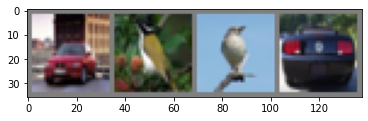

In [3]:
def imgshow(img):
    npimg = (img/2 + 0.5).numpy()
    plt.imshow(npimg.transpose(1,2,0))
    plt.show

dataiter = iter(trainloader)
images, labels = dataiter.next()

imgshow(tv.utils.make_grid(images))
print(' '.join('%5s' % classes [labels[j]] for j in range(batch_size)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [5]:
crit = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

plane plane plane horse
tensor([[ 0.0779, -0.0650, -0.0228, -0.1024, -0.0599,  0.0294,  0.0141,  0.0626,
          0.0341, -0.0559],
        [ 0.0717, -0.0659, -0.0183, -0.0999, -0.0586,  0.0281,  0.0161,  0.0598,
          0.0332, -0.0588],
        [ 0.0716, -0.0748, -0.0199, -0.0998, -0.0564,  0.0164,  0.0160,  0.0648,
          0.0382, -0.0540],
        [ 0.0663, -0.0773, -0.0209, -0.0996, -0.0637,  0.0220,  0.0179,  0.0684,
          0.0383, -0.0570]], grad_fn=<AddmmBackward>) tensor([1, 5, 1, 9])


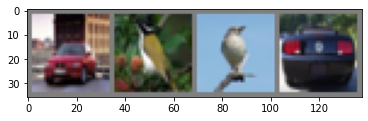

In [8]:
out = net(images)

_, idx = out.max(1)

imgshow(tv.utils.make_grid(images))
print(' '.join('%5s' % classes [idx[j]] for j in range(batch_size)))

print(out, labels)
# loss = crit(out, labels)
# out.shape, labels.shape

In [ ]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        opt.zero_grad()
        out = net(inputs)
        print(out, labels)
        loss = crit(out, labels)
        loss.backward() 
        
        opt.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

In [73]:
t.save(net.state_dict(), PATH)

Groundtruth:  cat  ship  ship plane
Prediction:  cat  ship  ship plane


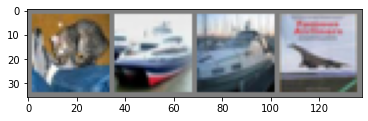

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imgshow(tv.utils.make_grid(images))
print('Groundtruth:'+' '.join('%5s' % classes [labels[j]] for j in range(batch_size)))

net.load_state_dict(t.load(PATH))

out = net(images)

_, idx = out.data.max(1)

print('Prediction:'+' '.join('%5s' % classes [idx[j]] for j in range(batch_size)))

In [18]:
# Performance on the whole dataset

correct, total = 0, 0
with t.no_grad():
    for data in testloader:
        images, labels = data
        out = net(images)
        _, pred = out.data.max(1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()


TypeError: unsupported operand type(s) for &: 'str' and 'float'

In [20]:
print("accuracy on 10,000 test images %d %%" % (100 * correct/total))

accuracy on 10,000 test images 56 %


In [23]:
# which classes performed the best?

class_correct, class_total = [0. for _ in range(10)], [0. for _ in range(10)]
with t.no_grad():
    for data in testloader:
        images, labels = data
        out = net(images)
        _, pred = out.data.max(1)
        c = (pred == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [24]:
for i in range(10):
    print("accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i]/class_total[i]))

accuracy of plane : 52 %
accuracy of   car : 78 %
accuracy of  bird : 40 %
accuracy of   cat : 35 %
accuracy of  deer : 39 %
accuracy of   dog : 54 %
accuracy of  frog : 77 %
accuracy of horse : 63 %
accuracy of  ship : 69 %
accuracy of truck : 59 %


In [26]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

In [28]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [35]:
it = iter(testloader)
images, labels = it.next()

out = net(images.to(device))

_, pred = out.data.max(1)

In [39]:
(pred == labels.to(device)).squeeze()

tensor([True, True, True, True], device='cuda:0')